In [ ]:
!pip install -q kagglehub


In [ ]:
import kagglehub

path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
print("Path to dataset files:", path)

# Inspect
import os
for root, dirs, files in os.walk(path):
    print(root)
    break


Using Colab cache for faster access to the 'driver-drowsiness-dataset-ddd' dataset.
Path to dataset files: /kaggle/input/driver-drowsiness-dataset-ddd
/kaggle/input/driver-drowsiness-dataset-ddd


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = "/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# All images (both Drowsy and Non Drowsy)
full_ds = datasets.ImageFolder(
    root=data_dir,
    transform=transform
)

print("Classes:", full_ds.classes)   # should show ['Drowsy', 'Non Drowsy']
print("Total images:", len(full_ds))


Classes: ['Drowsy', 'Non Drowsy']
Total images: 41793


In [ ]:
from torch.utils.data import DataLoader, random_split
# train, val and test split- 75/15/15
train_frac=0.7
n_total=len(full_ds)
n_train=int(train_frac * n_total)
n_val=int(0.15 * n_total)
n_test  = n_total - n_train - n_val
train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2)

In [ ]:
import os
import torch.nn as nn
import torch
from torchvision import datasets, transforms, models
from tqdm import tqdm
# 2. Frozen ResNet-18 (transfer learning)
# -----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load ResNet-18 with ImageNet weights
try:
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
except:
    # Fallback for older torchvision
    model = models.resnet18(pretrained=True)

# Freeze ALL backbone layers first
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully-connected layer: 512 -> 2 classes (drowsy / non-drowsy)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Only the new FC layer should be trainable
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 239MB/s]


In [ ]:
# 3. Train / Eval helper functions
# -----------------------------

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)          # [B, 2]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 10
best_val_acc = 0.0
best_state_dict = None

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict().copy()
        print("✅ New best model (val acc improved)")

# Load best weights
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with val acc = {best_val_acc:.4f}")

# -----------------------------
# 5. Final test accuracy
# -----------------------------

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test acc : {test_acc:.4f}")


Epoch 1/10


Train loss: 0.2305 | Train acc: 0.9296
Val   loss: 0.1128 | Val   acc: 0.9742
✅ New best model (val acc improved)

Epoch 2/10


Train loss: 0.1029 | Train acc: 0.9736
Val   loss: 0.0666 | Val   acc: 0.9868
✅ New best model (val acc improved)

Epoch 3/10


Train loss: 0.0740 | Train acc: 0.9818
Val   loss: 0.0538 | Val   acc: 0.9884
✅ New best model (val acc improved)

Epoch 4/10


Train loss: 0.0613 | Train acc: 0.9839
Val   loss: 0.0452 | Val   acc: 0.9898
✅ New best model (val acc improved)

Epoch 5/10


Train loss: 0.0544 | Train acc: 0.9857
Val   loss: 0.0371 | Val   acc: 0.9909
✅ New best model (val acc improved)

Epoch 6/10


Train loss: 0.0493 | Train acc: 0.9874
Val   loss: 0.0320 | Val   acc: 0.9927
✅ New best model (val acc improved)

Epoch 7/10


Train loss: 0.0446 | Train acc: 0.9881
Val   loss: 0.0393 | Val   acc: 0.9885

Epoch 8/10


Train loss: 0.0424 | Train acc: 0.9884
Val   loss: 0.0321 | Val   acc: 0.9907

Epoch 9/10


Train loss: 0.0393 | Train acc: 0.9886
Val   loss: 0.0248 | Val   acc: 0.9936
✅ New best model (val acc improved)

Epoch 10/10


Train loss: 0.0374 | Train acc: 0.9890
Val   loss: 0.0259 | Val   acc: 0.9928

Loaded best model with val acc = 0.9936



Test loss: 0.0252
Test acc : 0.9927


In [ ]:
import torch

# make sure 'model' holds the best weights
torch.save(model.state_dict(), "resnet_drowsy.pth")
print("Saved ResNet weights to resnet_drowsy.pth")


Saved ResNet weights to resnet_drowsy.pth


In [ ]:
from google.colab import files
files.download("resnet_drowsy.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install mediapipe opencv-python-headless


In [ ]:
import cv2
import mediapipe as mp
import numpy as np

mp_face_mesh_solution = mp.solutions.face_mesh
face_mesh = mp_face_mesh_solution.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.7
)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
import cv2
import numpy as np

def get_landmarks(image_path):
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        return None  # unreadable

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # use the global face_mesh instance
    results = face_mesh.process(img_rgb)
    if not results.multi_face_landmarks:
        return None

    lm = results.multi_face_landmarks[0]
    points = np.array([[p.x * w, p.y * h] for p in lm.landmark])
    return points  # shape: [478, 2] in your case


In [ ]:
# to get the understanding whether the get landmarks is working or not
# 478 landmarks
from pathlib import Path

sample_img_path, sample_label = full_ds.samples[0]
print("Sample image path string:", sample_img_path)
print("Sample label index:", sample_label)

sample_img = Path(sample_img_path)
landmarks = get_landmarks(sample_img)
print("Type:", type(landmarks))
if landmarks is not None:
    print("Shape:", landmarks.shape)
    print("First 5 points:\n", landmarks[:5])
else:
    print("No landmarks detected.")


Sample image path string: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0001.png
Sample label index: 0
Type: <class 'numpy.ndarray'>
Shape: (478, 2)
First 5 points:
 [[111.7458837  166.5125649 ]
 [111.24089402 134.05643427]
 [111.55972093 145.42781478]
 [106.00892055 108.28683358]
 [111.38980123 125.14841247]]


Sample image path string: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0001.png
Sample label index: 0


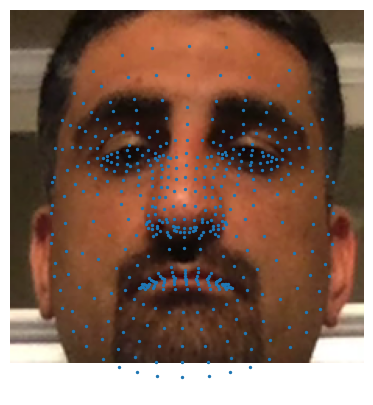

In [ ]:
import matplotlib.pyplot as plt

def show_landmarks(image_path, landmarks):
    img_bgr = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=2)
    plt.axis("off")
    plt.show()

sample_img_path, sample_label = full_ds.samples[0]
print("Sample image path string:", sample_img_path)
print("Sample label index:", sample_label)

sample_img = Path(sample_img_path)
landmarks = get_landmarks(sample_img)

if landmarks is not None:
    show_landmarks(sample_img, landmarks)
else:
    print("No landmarks detected for this image.")


In [ ]:
import numpy as np
import math

RIGHT_EYE_EAR = [33, 160, 158, 133, 153, 144]
LEFT_EYE_EAR  = [362, 385, 387, 263, 373, 380]

MOUTH_LEFT_CORNER  = 61
MOUTH_RIGHT_CORNER = 291
MOUTH_UPPER_MID    = 0
MOUTH_LOWER_MID    = 17

NOSE_TIP        = 1
CHIN            = 152
LEFT_EYE_CORNER = 263
RIGHT_EYE_CORNER= 33


def euclidean_dist(p1, p2):
    return np.linalg.norm(p1 - p2)


def eye_aspect_ratio(landmarks, eye_idx):
    p1 = landmarks[eye_idx[0]]
    p2 = landmarks[eye_idx[1]]
    p3 = landmarks[eye_idx[2]]
    p4 = landmarks[eye_idx[3]]
    p5 = landmarks[eye_idx[4]]
    p6 = landmarks[eye_idx[5]]

    d1 = euclidean_dist(p2, p6)   # vertical
    d2 = euclidean_dist(p3, p5)   # vertical
    d3 = euclidean_dist(p1, p4)   # horizontal

    return (d1 + d2) / (2.0 * d3 + 1e-6)


def mouth_aspect_ratio(landmarks):
    left_corner  = landmarks[MOUTH_LEFT_CORNER]
    right_corner = landmarks[MOUTH_RIGHT_CORNER]
    upper_mid    = landmarks[MOUTH_UPPER_MID]
    lower_mid    = landmarks[MOUTH_LOWER_MID]

    mouth_width  = euclidean_dist(left_corner, right_corner)
    mouth_height = euclidean_dist(upper_mid, lower_mid)

    return mouth_height / (mouth_width + 1e-6)


def yawn_flag_from_mar(mar, threshold=0.6):
    return int(mar > threshold)


def head_tilt_angle_deg(landmarks):
    left_eye  = landmarks[LEFT_EYE_CORNER]
    right_eye = landmarks[RIGHT_EYE_CORNER]

    dx = right_eye[0] - left_eye[0]
    dy = right_eye[1] - left_eye[1]

    angle_deg = math.degrees(math.atan2(dy, dx))

    # Normalize to [-90, 90] so horizontal ≈ 0, head slightly tilted ± small angle
    if angle_deg < -90:
        angle_deg += 180
    elif angle_deg > 90:
        angle_deg -= 180

    return angle_deg


def head_pitch_proxy(landmarks):
    nose = landmarks[NOSE_TIP]
    chin = landmarks[CHIN]

    nose_chin = euclidean_dist(nose, chin)

    left_eye  = landmarks[LEFT_EYE_CORNER]
    right_eye = landmarks[RIGHT_EYE_CORNER]
    eye_dist  = euclidean_dist(left_eye, right_eye)

    return nose_chin / (eye_dist + 1e-6)


In [ ]:
feats = {}

feats["left_ear"]  = eye_aspect_ratio(landmarks, LEFT_EYE_EAR)
feats["right_ear"] = eye_aspect_ratio(landmarks, RIGHT_EYE_EAR)
feats["avg_ear"]   = 0.5 * (feats["left_ear"] + feats["right_ear"])

feats["mar"]       = mouth_aspect_ratio(landmarks)
feats["yawn_flag"] = yawn_flag_from_mar(feats["mar"], threshold=0.6)

feats["tilt_deg"]  = head_tilt_angle_deg(landmarks)
feats["pitch_val"] = head_pitch_proxy(landmarks)

for k, v in feats.items():
    print(f"{k}: {v}")


left_ear: 0.2061586838993208
right_ear: 0.23186632812731375
avg_ear: 0.2190125060133173
mar: 0.20866927068531832
yawn_flag: 0
tilt_deg: 0.35295954913542005
pitch_val: 0.913783359547747


In [ ]:
import csv
from pathlib import Path

rows = []

# full_ds is your ImageFolder
print("Total samples:", len(full_ds))

for img_path_str, label_idx in full_ds.samples:
    img_path = Path(img_path_str)

    lm = get_landmarks(img_path)
    if lm is None:
        # no face / landmarks failed → skip this image
        continue

    # EAR
    left_ear  = eye_aspect_ratio(lm, LEFT_EYE_EAR)
    right_ear = eye_aspect_ratio(lm, RIGHT_EYE_EAR)
    avg_ear   = 0.5 * (left_ear + right_ear)

    # MAR + yawn
    mar       = mouth_aspect_ratio(lm)
    yawn_flag = yawn_flag_from_mar(mar, threshold=0.6)

    # head pose
    tilt_deg  = head_tilt_angle_deg(lm)
    pitch_val = head_pitch_proxy(lm)

    rows.append([
        img_path_str,
        label_idx,   # 0 = Drowsy, 1 = Non Drowsy (check full_ds.classes)
        avg_ear,
        mar,
        yawn_flag,
        tilt_deg,
        pitch_val,
    ])

print("Valid rows (with landmarks):", len(rows))

with open("fatigue_features.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "image_path", "label",
        "EAR", "MAR", "yawn_flag",
        "tilt_deg", "pitch_ratio"
    ])
    writer.writerows(rows)

print("Saved fatigue_features.csv ✅")


Total samples: 41793
Valid rows (with landmarks): 40663
Saved fatigue_features.csv ✅


In [ ]:
import pandas as pd

df = pd.read_csv("fatigue_features.csv")
print(df.head())
print(df["label"].value_counts())


                                          image_path  label       EAR  \
0  /kaggle/input/driver-drowsiness-dataset-ddd/Dr...      0  0.219013   
1  /kaggle/input/driver-drowsiness-dataset-ddd/Dr...      0  0.226987   
2  /kaggle/input/driver-drowsiness-dataset-ddd/Dr...      0  0.246948   
3  /kaggle/input/driver-drowsiness-dataset-ddd/Dr...      0  0.284266   
4  /kaggle/input/driver-drowsiness-dataset-ddd/Dr...      0  0.320063   

        MAR  yawn_flag  tilt_deg  pitch_ratio  
0  0.208669          0  0.352960     0.913783  
1  0.229522          0  0.750290     0.872786  
2  0.213274          0  0.767874     0.875800  
3  0.216778          0  0.838777     0.882077  
4  0.202831          0  0.657126     0.909412  
label
0    21839
1    18824
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ["EAR", "MAR", "yawn_flag", "tilt_deg", "pitch_ratio"]

X = df[feature_cols].values
y = df["label"].values  # 0/1

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 15% val, 15% test from the 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (28464, 5) Val: (6099, 5) Test: (6100, 5)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

log_reg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])

log_reg_model.fit(X_train, y_train)

val_pred = log_reg_model.predict(X_val)
test_pred = log_reg_model.predict(X_test)

print("LogReg – Val accuracy :", accuracy_score(y_val, val_pred))
print("LogReg – Test accuracy:", accuracy_score(y_test, test_pred))
print("\nLogReg – Test classification report:\n",
      classification_report(y_test, test_pred))
print("\nLogReg – Confusion matrix:\n",
      confusion_matrix(y_test, test_pred))


LogReg – Val accuracy : 0.6463354648303
LogReg – Test accuracy: 0.6381967213114754

LogReg – Test classification report:
               precision    recall  f1-score   support

           0       0.64      0.75      0.69      3276
           1       0.64      0.51      0.57      2824

    accuracy                           0.64      6100
   macro avg       0.64      0.63      0.63      6100
weighted avg       0.64      0.64      0.63      6100


LogReg – Confusion matrix:
 [[2452  824]
 [1383 1441]]


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        max_iter=300,
        random_state=42
    ))
])

mlp_model.fit(X_train, y_train)

val_pred_mlp = mlp_model.predict(X_val)
test_pred_mlp = mlp_model.predict(X_test)

print("MLP – Val accuracy :", accuracy_score(y_val, val_pred_mlp))
print("MLP – Test accuracy:", accuracy_score(y_test, test_pred_mlp))
print("\nMLP – Test classification report:\n",
      classification_report(y_test, test_pred_mlp))
print("\nMLP – Confusion matrix:\n",
      confusion_matrix(y_test, test_pred_mlp))


MLP – Val accuracy : 0.883587473356288
MLP – Test accuracy: 0.9001639344262296

MLP – Test classification report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      3276
           1       0.92      0.85      0.89      2824

    accuracy                           0.90      6100
   macro avg       0.90      0.90      0.90      6100
weighted avg       0.90      0.90      0.90      6100


MLP – Confusion matrix:
 [[3077  199]
 [ 410 2414]]


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
import joblib

joblib.dump(mlp_model, "fatigue_mlp.joblib")
print("Saved MLP model to fatigue_mlp.joblib")


Saved MLP model to fatigue_mlp.joblib


In [ ]:
from google.colab import files
files.download("fatigue_mlp.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>